In [62]:
import sys

import numpy as np

import paths
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils

import matplotlib.pyplot as plt

In [63]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

In [8]:
lat = lats[3]
lat_str = strf_utils.format_lat_lon(lat)

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

In [14]:
#outputs = xr.open_dataset(f"{data_home}/streamfunctions_ecco/{lat}/PSI_residual{lat}.nc")
outputs_fp = f"{data_home}/ecco_data_minimal/{lat_str}_moc_depth.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)
    
print(outputs.shape)

outputs = np.expand_dims(outputs, 1) # grabbing just 60S
print(outputs.shape)
outputs = xr.Dataset(data_vars = {'moc' : (["time", "latitude"], outputs)}, coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60)})
outputs

(312,)
(312, 1)


<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int32 -60
Data variables:
    moc       (time, latitude) float64 9.155 2.625 4.966 ... 7.538 13.98 9.485

In [15]:
date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


In [73]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["time", "longitude"])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np

# Necessary step to do convolutions along the right axis with pytorch tensors!
dims = list(range(X.ndim))  
dims[1], dims[-1] = dims[-1], dims[1]  
X_transposed = np.transpose(X, dims)

conv_dims = 2
if len(X.shape) == (conv_dims + 1):
    X = np.expand_dims(X, axis=-1)

y = strength_np[-X.shape[0]:]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'longitude', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 720, 5)
(312, 720, 5)
unsqueeze

Inputs shape: (312, 720, 5, 1)
Outputs shape: (312,)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


In [58]:
import importlib
from models import train, SimDataset, CNN1D, CNN2D, CNN3D

importlib.reload(train)
importlib.reload(CNN1D)
importlib.reload(CNN2D)
importlib.reload(SimDataset)

<module 'models.SimDataset' from 'C:\\Users\\aline\\OTP\\models\\SimDataset.py'>

device: cpu
931 parameters.


100%|██████████| 2500/2500 [09:30<00:00,  4.38it/s]


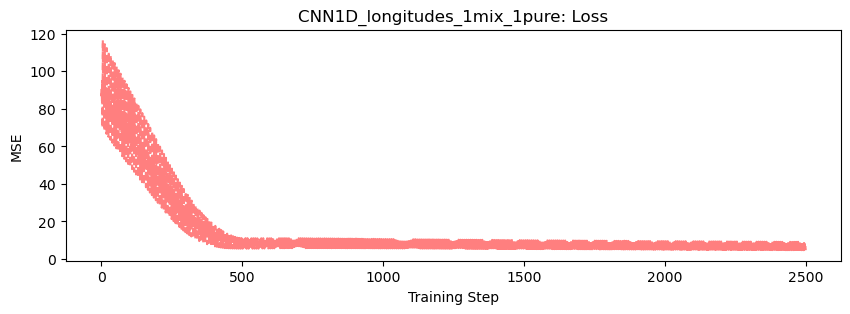

final loss: 4.689939516411346
model saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/saved_models/CNN1D_longitudes_1mix_1pure.pt
loss curve saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/loss_curves/CNN1D_longitudes_1mix_1pure.png


In [60]:
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 1
n_features = 5
n_channels = n_features * 3
kernel_size = (3,3)

model = CNN2D.CNN2D(
    n_pure_layers=n_pure_layers, 
    n_mix_layers=n_mix_layers, 
    n_features=n_features, 
    n_channels=n_channels,
    kernel_size=kernel_size,
    dropout=dropout
).double()

save_dir = paths.MODELS_OUTPUT
loss1 = train.train_model(model, 'CNN1D_longitudes_1mix_1pure', Xt_train, Yt_train, save_dir=save_dir, conv_dim=2)

In [ ]:
model.

device: cpu
device: cpu
Test R^2: 0.107
Test MSE: 8.464
Test RMSE: 2.909
Test MAE: 2.313


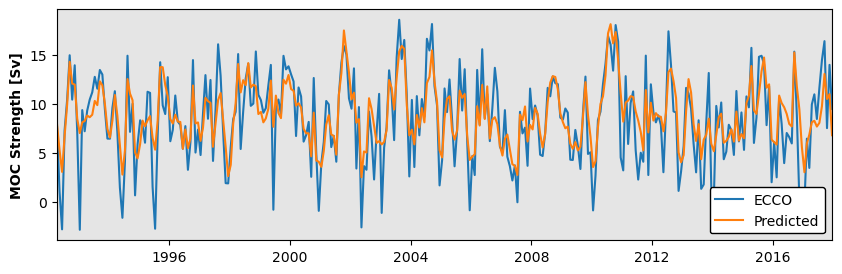

In [61]:
# Extracting all predictions in time order
train_set_pred = train.predict(model, 'CNN1D', Xt_train, Yt_train, conv_dim=2, save_dir=save_dir)
test_set_pred = train.predict(model, 'CNN1D', Xt_test, Yt_test, conv_dim=2, save_dir=save_dir)
all_preds = np.concatenate([train_set_pred, test_set_pred])

r2 = round(r2_score(test_set_pred, y_test), 3)
mse = round(mean_squared_error(test_set_pred, y_test), 3)
rmse = round(root_mean_squared_error(test_set_pred, y_test), 3)
mae = round(mean_absolute_error(test_set_pred, y_test), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

time = outputs.time.values[-X.shape[0]:]

fig, ax = timeseries_comparison(all_preds, y, time, len(y))
plt.show()

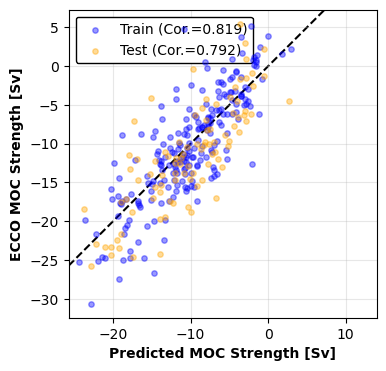

In [96]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(train_set_pred).squeeze()
y_pred_test = np.array(test_set_pred).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()